In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
%matplotlib inline

In [72]:
class MD_based_RS:
    """
    类说明： 基于矩阵分解的推荐系统
    """
    def __init__(self,R,W,TR,TW,Parameters):
        """
        函数说明：初始化推荐系统所需参数
        参数：
            R - 训练集评分矩阵
            W - 训练集权重矩阵，消去不存在的评分的影响
            TR - 测试评分矩阵
            TW - 测试权重矩阵
            Parameters - 超参数
        """
        self.Rating_Matrix=R
        self.n_rows=Parameters['n_rows']
        self.n_cols=Parameters['n_cols']
        self.K=Parameters['K']    #潜在特征数，通常在10-100间
        self.penalty_factor=Parameters['penalty_factor']    #惩罚因子
        self.max_loops=Parameters['max_loops']
        self.epsilon=Parameters['epsilon']    #判断收敛
        self.loops=100; #收敛时的循环次数
        
        self.Weight_Matrix=W
        self.Test_Rating_Matrix=TR
        self.Test_Weight_Matrix=TW
        
        #self.P_users;    #用户因子矩阵
        #self.Q_item;    #物品因子矩阵
        
    def RMSE(self,Rating_Matrix,Weight_Matrix):
        """
        函数说明：计算均方根误差
        参数说明：
            Rating_Matrix - 上一轮评分矩阵
        返回值：
            rmse - 均方根误差
        """
        
        Predict=self.P_users.dot(self.Q_item.T)
        rmse=np.sqrt((Weight_Matrix*np.asarray((Rating_Matrix-Predict))**2).sum()/(self.n_rows*self.n_cols))
        return rmse
    
    def loss(self,Rating_Matrix,Weight_Matrix):
        """
        函数说明：计算loss
        参数说明：
            Rating_Matrix - 评分矩阵
            Weight_Matrix - 权重矩阵
        返回值：
            loss - 损失
        """
        Predict=self.P_users.dot(self.Q_item.T)
        SEL=np.sum((Weight_Matrix*np.asarray(Rating_Matrix-Predict))**2)
        #正则化
        RP=0
        RQ=0
        for i in range(0,self.n_rows):
            RP+=self.penalty_factor*self.P_users[i,:].dot(self.P_users[i,:].T)
        for i in range(0,self.n_cols):
            RQ+=self.penalty_factor*self.Q_item[i,:].dot(self.Q_item[i,:].T)
        LOSS=SEL+RP+RQ
        return LOSS/(self.n_rows*self.n_cols)
    
    def updateMatrix(self,matrix_fixed):
        """
        函数说明：每一次迭代更新因子矩阵
        参数说明：
            matrix_fixed - 固定的因子矩阵
        返回值：
            new_matrix - 更新的因子矩阵
        """
        tic=time.time
        if matrix_fixed=="P_users":
            new_matrix=np.linalg.solve(np.dot(self.P_users.T,self.P_users)+
                                      self.penalty_factor*np.eye(self.K),
                                     np.dot(self.P_users.T,self.Rating_Matrix)).T
        else:
            new_matrix=np.linalg.solve(np.dot(self.Q_item.T,self.Q_item)+
                                       self.penalty_factor*np.eye(self.K),
                                      np.dot(self.Q_item.T,self.Rating_Matrix.T)).T
        #print('更新 {} 成功，用时:{:0.5f}s'.format(matrix_fixed,time.time()-tic))
        return new_matrix
    
    def draw(self):
        """
        函数说明：loss和rmse随迭代次数的变化
        """
        loops=self.loops
        plt.plot(np.arange(0,loops-1,1),self.train_Rmse[0:loops-1],label='Train_RMSE')
        plt.plot(np.arange(0, loops - 1, 1), self.test_Rmse[0:loops - 1], label='Test_RMSE')
        plt.xlabel('loops')
        plt.ylabel('RMSE')
        plt.title('RMSE In Train And Test')
        plt.legend()
        plt.show()
        
        #loops=self.loops
        plt.plot(np.arange(0, loops - 1, 1), self.test_Loss[0:loops - 1], label='Test_Loss')
        plt.plot(np.arange(0, loops - 1, 1), self.train_Loss[0:loops - 1], label='Train_Loss')
        plt.xlabel('loops')
        plt.ylabel('loss')
        plt.title('Loss In Train And Test')
        plt.legend()
        plt.show()
        
    def train(self):
        """
        函数说明：训练模型
        """
        tic=time.time()
        self.train_Rmse=[]
        self.train_Loss=[]
        self.test_Rmse=[]
        self.test_Loss=[]
        self.P_users=np.random.normal(size=(self.n_rows,self.K))
        self.Q_item=np.random.normal(size=(self.n_cols,self.K))
        count=0
        rmse_changed=1
        
        while count<self.max_loops:
            #print(rmse_changed)
            if rmse_changed<self.epsilon:
                #收敛
                print('rmse变化量为:{} < epsilon:{}'.format(rmse_changed,self.epsilon))
                self.loops=count+1;
                break;
            else:
                self.P_users=self.updateMatrix('Q_item')
                self.Q_item=self.updateMatrix("P_users")
                
                #记录RMSE和LOSS
                train_rmse=self.RMSE(self.Rating_Matrix,self.Weight_Matrix)
                train_loss=self.loss(self.Rating_Matrix,self.Weight_Matrix)
                test_rmse=self.RMSE(self.Test_Rating_Matrix,Test_Weight_Matrix)
                test_loss=self.loss(self.Test_Rating_Matrix,self.Test_Weight_Matrix)
                
                #计算变化的幅度
                if count==0:
                    #第一次迭代
                    rmse_changed=1
                else:
                    rmse_changed=self.train_Rmse[-1]-train_rmse
                
                #插入数组中
                self.train_Rmse.append(train_rmse)
                self.train_Loss.append(train_loss)
                self.test_Rmse.append(test_rmse)
                self.test_Loss.append(test_loss)
                #print(train_rmse)
                print('第{}次循环:\n rmse变化量:{} \n Train- RMSE:{:0.2f},Loss:{:0.2f} \n Test- RMSE:{:0.2f},Loss:{:0.2f}\n'.format(count+1,rmse_changed,train_rmse,train_loss,test_rmse,test_loss))
            
                count+=1
        
        print("认为已收敛，总循环次数：{}，总用时：{:0.2f}秒\n".format(count,time.time()-tic))
    

In [73]:
def loadData(parameters,directory_path):
    """
    函数说明：导入数据集,mode==0,原始数据集；mode=1，已切分数据集
    参数说明：
        parameters - 一组超参
        directory_path - 数据集路径
    """
    tic=time.time()
    n_rows=parameters['n_rows']
    n_cols=parameters['n_cols']
    mode=parameters['mode']
    
    if mode==0:
        file_path=directory_path+'/u.data'
        Train_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        Test_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        origin_data=np.loadtxt(file_path)
        train,test=train_test_split(origin_data,test_size=0.2,random_state=1)
        for i in range(0,train.shape[0]):
            user_id=int(train[i][0])
            item_id=int(train[i][1])
            rating=train[i][2]
            #user_id和item_id没有0
            Train_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Train_Weight_Matrix[user_id - 1, item_id - 1] = 1
        for i in range(0,test.shape[0]):
            user_id=int(test[i][0])
            item_id=int(test[i][1])
            rating=test[i][2]
            Test_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Test_Weight_Matrix[user_id - 1, item_id - 1] = 1
        print('成功导入原始数据集，并用留出法切分。用时:{:0.2f}'.format(time.time()-tic))
        return Train_Rating_Matrix,Train_Weight_Matrix,Test_Rating_Matrix,Test_Weight_Matrix
    
    if mode==1:
        Train_Rating_Matrixs=[]
        Train_Weight_Matrixs=[]
        Test_Rating_Matrixs=[]
        Test_Weight_Matrixs=[]
        for i in range(1,6):
            Train_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            train_path = directory_path + '/u{}.base'.format(i)
            test_path = directory_path + '/u{}.test'.format(i)
            train_data = np.loadtxt(train_path)
            test_data = np.loadtxt(test_path)
            for i in range(0, train_data.shape[0]):
                user_id = int(train_data[i][0])
                item_id = int(train_data[i][1])
                rating = train_data[i][2]
                #user_id和item_id没有0
                Train_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Train_Weight_Matrix[user_id - 1, item_id - 1] = 1
            for i in range(0, test_data.shape[0]):
                user_id = int(test_data[i][0])
                item_id = int(test_data[i][1])
                rating = test_data[i][2]
                Test_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Test_Weight_Matrix[user_id - 1, item_id - 1] = 1
            Train_Rating_Matrixs.append(Train_Rating_Matrix)
            Train_Weight_Matrixs.append(Train_Weight_Matrix)
            Test_Rating_Matrixs.append(Test_Rating_Matrix)
            Test_Weight_Matrixs.append(Test_Weight_Matrix)
        print('成功导入已切分数据集。 用时:{:0.2f}'.format(time.time()-tic))
        Data=[Train_Rating_Matrixs,Train_Weight_Matrixs,Test_Rating_Matrixs,Test_Rating_Matrixs]
        return Data
    

In [74]:
def draw(loops,dic,x_label,y_label,title):
    
    for m_label,li in dic.items():
        plt.plot(np.arange(0, loops - 1, 1), li[0:loops - 1], label=m_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [75]:

if __name__ == '__main__':

    #设置两种情况下的超参
    prefix=os.getcwd()
    dic_path=prefix+'/ml-100k'
    # Use the full dataset:u.data
    Parameters_1={
        'n_rows':943,
        'n_cols':1682,
        'mode':0,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
    # Use the five divided dataset
    Parameters_2={
        'n_rows':943,
        'n_cols':1682,
        'mode':1,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
        

成功导入原始数据集，并用留出法切分。用时:0.90
第1次循环:
 rmse变化量:1 
 Train- RMSE:0.59,Loss:0.37 
 Test- RMSE:0.33,Loss:0.13

第2次循环:
 rmse变化量:0.07808333055082473 
 Train- RMSE:0.51,Loss:0.28 
 Test- RMSE:0.31,Loss:0.12

第3次循环:
 rmse变化量:0.012098794255523793 
 Train- RMSE:0.50,Loss:0.26 
 Test- RMSE:0.31,Loss:0.12

第4次循环:
 rmse变化量:0.005095721433003186 
 Train- RMSE:0.49,Loss:0.26 
 Test- RMSE:0.31,Loss:0.11

第5次循环:
 rmse变化量:0.0028681823803641815 
 Train- RMSE:0.49,Loss:0.25 
 Test- RMSE:0.31,Loss:0.11

第6次循环:
 rmse变化量:0.0018588713873584073 
 Train- RMSE:0.49,Loss:0.25 
 Test- RMSE:0.31,Loss:0.11

第7次循环:
 rmse变化量:0.0013118718997013334 
 Train- RMSE:0.49,Loss:0.25 
 Test- RMSE:0.31,Loss:0.11

第8次循环:
 rmse变化量:0.000981903850208965 
 Train- RMSE:0.49,Loss:0.25 
 Test- RMSE:0.31,Loss:0.11

第9次循环:
 rmse变化量:0.0007688712339363746 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.31,Loss:0.11

第10次循环:
 rmse变化量:0.0006238702973489496 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.31,Loss:0.11

第11次循环:
 rmse变化量:0.0005201688477708966

第87次循环:
 rmse变化量:1.2607847814927187e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第88次循环:
 rmse变化量:1.2353183708735394e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第89次循环:
 rmse变化量:1.2105600781076031e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第90次循环:
 rmse变化量:1.1864816126860855e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第91次循环:
 rmse变化量:1.1630563474751554e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第92次循环:
 rmse变化量:1.1402591948095342e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第93次循环:
 rmse变化量:1.1180664934495876e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第94次循环:
 rmse变化量:1.0964559044757127e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第95次循环:
 rmse变化量:1.0754063162254912e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第96次循环:
 rmse变化量:1.0548977562752082e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.31,Loss:0.10

第97次循环:
 rmse变化量:1.0

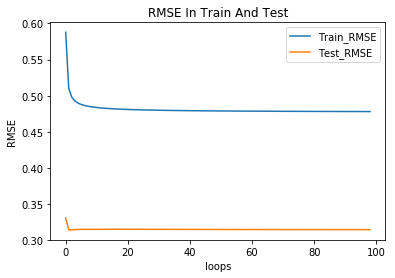

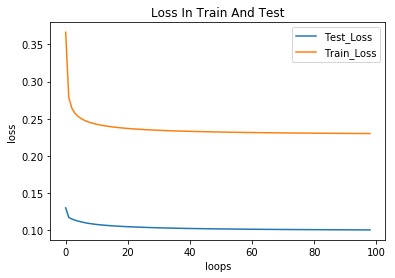

In [76]:
    #使用整个数据集训练一个模型
    Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix = loadData(Parameters_1,dic_path)
    fModel_0 = MD_based_RS(Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix, Parameters_1)
    fModel_0.train()
    fModel_0.draw()

In [77]:
    #使用五个已切分的数据集训练五个不同的模型并画出曲线
    Data=loadData(Parameters_2,dic_path)
    Models=[]
    for i in range(0,5):
        tic=time.time()
        print('开始训练 Model_{}'.format(i))
        model=MD_based_RS(Data[0][i],Data[1][i],Data[2][i],Data[3][i],Parameters_2)
        model.train()
        print('Model_{} 训练完毕。用时 {:0.2f}s'.format(i,time.time()-tic))
        Models.append(model)

成功导入已切分数据集。 用时:4.61
开始训练 Model_0
第1次循环:
 rmse变化量:1 
 Train- RMSE:0.58,Loss:0.36 
 Test- RMSE:0.22,Loss:2.30

第2次循环:
 rmse变化量:0.08059225837082862 
 Train- RMSE:0.50,Loss:0.27 
 Test- RMSE:0.26,Loss:2.12

第3次循环:
 rmse变化量:0.011860455353165211 
 Train- RMSE:0.49,Loss:0.26 
 Test- RMSE:0.26,Loss:2.11

第4次循环:
 rmse变化量:0.005020234193311213 
 Train- RMSE:0.48,Loss:0.25 
 Test- RMSE:0.26,Loss:2.11

第5次循环:
 rmse变化量:0.0028226059444559914 
 Train- RMSE:0.48,Loss:0.25 
 Test- RMSE:0.27,Loss:2.11

第6次循环:
 rmse变化量:0.0018378930017139972 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.27,Loss:2.11

第7次循环:
 rmse变化量:0.001310501971487965 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.27,Loss:2.11

第8次循环:
 rmse变化量:0.0009916083154997701 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.27,Loss:2.11

第9次循环:
 rmse变化量:0.0007822049691905142 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.27,Loss:2.11

第10次循环:
 rmse变化量:0.0006363035624326052 
 Train- RMSE:0.48,Loss:0.24 
 Test- RMSE:0.27,Loss:2.11

第11次循环:
 rmse变化量:0.000529958398


第87次循环:
 rmse变化量:1.2806835956169493e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第88次循环:
 rmse变化量:1.254216342688741e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第89次循环:
 rmse变化量:1.2285488872498807e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第90次循环:
 rmse变化量:1.2036483706068246e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第91次循环:
 rmse变化量:1.179483675112225e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第92次循环:
 rmse变化量:1.1560253117770536e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第93次循环:
 rmse变化量:1.1332453157597566e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第94次循环:
 rmse变化量:1.1111171500322037e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第95次循环:
 rmse变化量:1.089615616112205e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第96次循环:
 rmse变化量:1.0687167711465051e-05 
 Train- RMSE:0.47,Loss:0.22 
 Test- RMSE:0.27,Loss:2.08

第97次循环:
 rmse变化量:1.048

第72次循环:
 rmse变化量:1.5717510076063146e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第73次循环:
 rmse变化量:1.53502883306067e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第74次循环:
 rmse变化量:1.499644162422653e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第75次循环:
 rmse变化量:1.4655286803166856e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第76次循环:
 rmse变化量:1.4326186263458052e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第77次循环:
 rmse变化量:1.4008544264199063e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第78次循环:
 rmse变化量:1.370180358195583e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第79次循环:
 rmse变化量:1.340544247618869e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第80次循环:
 rmse变化量:1.3118971926018297e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第81次循环:
 rmse变化量:1.2841933123119986e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.94

第82次循环:
 rmse变化量:1.257389

第63次循环:
 rmse变化量:2.1925690003365972e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第64次循环:
 rmse变化量:2.1288942916808384e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第65次循环:
 rmse变化量:2.0678497635484572e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第66次循环:
 rmse变化量:2.0092912589197987e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第67次循环:
 rmse变化量:1.953084462252841e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第68次循环:
 rmse变化量:1.8991041021598765e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第69次循环:
 rmse变化量:1.8472332304064754e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第70次循环:
 rmse变化量:1.7973625695444362e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第71次循环:
 rmse变化量:1.7493899210851982e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第72次循环:
 rmse变化量:1.703219627363639e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.84

第73次循环:
 rmse变化量:1.658

第52次循环:
 rmse变化量:2.9648366188461672e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第53次循环:
 rmse变化量:2.8690483248217102e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第54次循环:
 rmse变化量:2.7780990228210012e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第55次循环:
 rmse变化量:2.6916415864775e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第56次循环:
 rmse变化量:2.6093614357791672e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第57次循环:
 rmse变化量:2.5309728588940317e-05 
 Train- RMSE:0.48,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第58次循环:
 rmse变化量:2.4562158029262093e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第59次循环:
 rmse变化量:2.384853069686832e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第60次循环:
 rmse变化量:2.316667860757793e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第61次循环:
 rmse变化量:2.251461624291906e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.85

第62次循环:
 rmse变化量:2.1890521

第40次循环:
 rmse变化量:4.302500181813107e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第41次循环:
 rmse变化量:4.123279690559922e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第42次循环:
 rmse变化量:3.956284693507062e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第43次循环:
 rmse变化量:3.8003252667617726e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第44次循环:
 rmse变化量:3.65435846207407e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第45次循环:
 rmse变化量:3.5174672349980174e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第46次循环:
 rmse变化量:3.388842625667854e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第47次循环:
 rmse变化量:3.267768698189677e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第48次循环:
 rmse变化量:3.153609806244573e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第49次循环:
 rmse变化量:3.045799814527239e-05 
 Train- RMSE:0.47,Loss:0.23 
 Test- RMSE:0.27,Loss:1.93

第50次循环:
 rmse变化量:2.9438329585

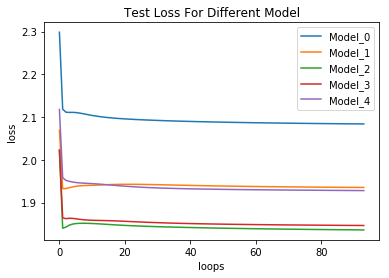

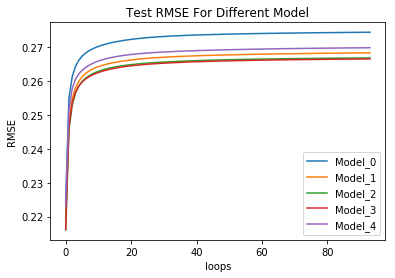

In [78]:
    #取最小的收敛次数
    min_loops=1000;
    for i in range(5):
        if(Models[i].loops<min_loops):
            min_loops=Models[i].loops
    
    #不同切分集的模型效果（loss）
    dic={'Model_0':Models[0].test_Loss,
         'Model_1': Models[1].test_Loss,
         'Model_2': Models[2].test_Loss,
         'Model_3': Models[3].test_Loss,
         'Model_4': Models[4].test_Loss,}
    #draw(Parameters_2['max_loops'],dic,'loops','loss','Test Loss For Different Model')
    draw(min_loops,dic,'loops','loss','Test Loss For Different Model')
    
    #不同切分集的模型效果（rmse）
    dic={'Model_0':Models[0].test_Rmse,
         'Model_1': Models[1].test_Rmse,
         'Model_2': Models[2].test_Rmse,
         'Model_3': Models[3].test_Rmse,
         'Model_4': Models[4].test_Rmse,}
    #draw(Parameters_2['max_loops'],dic,'loops','RMSE','Test RMSE For Different Model')
    draw(min_loops,dic,'loops','RMSE','Test RMSE For Different Model')